## Problem 1: Finding the Optimal $k$ and Bootstrap Iterations

In this task, you will use the $K$-Nearest Neighbors (KNN) classifier to classify handwritten digits from the MNIST dataset. The goal is to determine:
1. The optimal number of neighbors ($k$) for the KNN classifier.
2. The optimal number of bootstrap iterations to obtain a confident estimate of the model’s accuracy.

You will:
1. Download and preprocess the MNIST dataset (use $10\%$ of the dataset for faster experimentation).
2. Implement bootstrap resampling to evaluate the KNN classifier for various values of $k$.
3. Experiment with different numbers of bootstrap iterations.
4. Determine the optimal values of $k$ and the minimum number of bootstrap iterations required for a confident result.

In [4]:
!pip install numpy matplotlib scikit-learn


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.utils import resample

import warnings
warnings.filterwarnings('ignore')

## Download the MNIST dataset

Note: This may take a moment 

In [3]:
mnist = fetch_openml('mnist_784', version=1)

In [ ]:
# Another approaches
import keras

(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

from sklearn.datasets import load_digits
data = load_digits()

## Preprocess the MNIST dataset

Normalize the pixel values (e.g., divide by $255$ to scale between $0$ and $1$)

In [4]:
X, y = mnist.data / 255.0, mnist.target.astype(int)  # normalize and convert labels to integer

In [ ]:
# Another approaches
from sklearn.preprocessing import MinMaxScaler

# Normalize the pixel values to be between 0 and 1
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

Select a random $10\%$ subset of the dataset for faster experimentation

In [70]:
X_data, _, y_data, _ = train_test_split(X, y, test_size=0.9, random_state=42)
print(X_data.shape, y_data.shape)

# Another approach
# sample_size = 7000 # int(0.1 * len(X_data))
# random_indices = np.random.choice(X_data.shape[0], sample_size, replace=False)
# X_data = X_data[random_indices]
# print(X_data[0])
# y_data = y_data[random_indices]

(7000, 784) (7000,)


## KNN Classifier

Iterate over different values of $k$, specifically $k = 1, 2, ..., 10$

In [11]:
k_values = range(1, 11)  # values of k to test [1, 10]
bootstrap_iterations = [1, 2, 11, 22, 44, 88]  # bootstrap iterations to test

## Bootstrap Resampling:

* For each value of $k$, perform several bootstrap iterations:
	* Resample the entire dataset with replacement to create a training set.
	* Train the KNN model on the resampled data.
	* Test the model on the remaining data points (out-of-bag data).
	* Compute and store the accuracy on the out-of-bag data for each iteration.

In [71]:
def bootstrap_resampling_knn(X_data, y_data, k_values, bootstrap_iterations):
	results = {k: [] for k in k_values}

	for k in k_values:
		knn = KNeighborsClassifier(n_neighbors=k)
		for n_bootstrap in bootstrap_iterations:
			bootstrap_accuracies = []

			for _ in range(n_bootstrap):
				# X_resampled, y_resampled = resample(X_data, y_data, random_state=None, replace=True)

				indices = np.random.choice(X_data.shape[0], size=X_data.shape[0], replace=True)
				X_resampled, y_resampled = X_data.iloc[indices], y_data.iloc[indices]
				oob_indices = np.setdiff1d(np.arange(X_data.shape[0]), indices)

				if len(oob_indices) == 0:
					print('oob_indices is empty!')
					continue

				X_oob, y_oob = X_data.iloc[oob_indices], y_data.iloc[oob_indices]

				knn.fit(X_resampled, y_resampled)
				y_pred = knn.predict(X_oob)
				accuracy = accuracy_score(y_oob, y_pred)
				bootstrap_accuracies.append(accuracy)

				# X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=None)
				# knn.fit(X_train, y_train)
				# y_pred = knn.predict(X_test)
				# accuracy = accuracy_score(y_test, y_pred)
				# bootstrap_accuracies.append(accuracy)

			results[k].append(np.mean(bootstrap_accuracies) if bootstrap_accuracies else np.nan)

	for k, mean_accuracy in results.items():
		print(f'Mean accuracy for k={k}: {mean_accuracy}')

	return results

In [72]:
results = bootstrap_resampling_knn(X_data, y_data, k_values, bootstrap_iterations)

Mean accuracy for k=1: [np.float64(0.9338006230529595), np.float64(0.9365411522165883), np.float64(0.9340396348949027), np.float64(0.9320980701178049), np.float64(0.9311975968626723), np.float64(0.9307847627675627)]
Mean accuracy for k=2: [np.float64(0.9164715066354411), np.float64(0.9227661818281425), np.float64(0.9214897614156499), np.float64(0.9240903154558605), np.float64(0.9216958637378948), np.float64(0.9231296372330999)]
Mean accuracy for k=3: [np.float64(0.9222179437812861), np.float64(0.9249127829584647), np.float64(0.9250307349091905), np.float64(0.9258482765164028), np.float64(0.926252428368731), np.float64(0.9253561207148082)]
Mean accuracy for k=4: [np.float64(0.9309810003877472), np.float64(0.9239480823495378), np.float64(0.9216774338196964), np.float64(0.9212896872366471), np.float64(0.9220356448643735), np.float64(0.9228655157976706)]
Mean accuracy for k=5: [np.float64(0.9219172787011983), np.float64(0.9238330046627361), np.float64(0.9277444555987929), np.float64(0.9253

## Determine Optimal k and Bootstrap Iterations:

* Experiment with different numbers of bootstrap iterations (e.g., try $1, 2, 11, 22, 44, 88$, etc.).
* Calculate the mean accuracy across bootstrap iterations for each $k$.
* Determine the optimal $k$ and the number of iterations required for a stable estimate.

## Plots

* Plot the mean accuracy for each value of $k$.
* Include another plot showing how the mean accuracy stabilizes with increasing bootstrap iterations.

In [73]:
mean_accuracies_k = {k: np.nanmean(results[k]) for k in k_values}
optimal_k = max(mean_accuracies_k, key=mean_accuracies_k.get)
stabilization_accuracies = results[optimal_k]


print("Optimal k:", optimal_k)
print("Mean accuracy per k:", mean_accuracies_k)
print("Stabilization accuracies:", stabilization_accuracies)

Optimal k: 1
Mean accuracy per k: {1: np.float64(0.9330769733187485), 2: np.float64(0.9216072110510147), 3: np.float64(0.9249363812081471), 4: np.float64(0.9237995607426122), 5: np.float64(0.9252542471704944), 6: np.float64(0.924687588059815), 7: np.float64(0.9267002123222267), 8: np.float64(0.9254957489819932), 9: np.float64(0.9246450034927342), 10: np.float64(0.9253235061268134)}
Stabilization accuracies: [np.float64(0.9338006230529595), np.float64(0.9365411522165883), np.float64(0.9340396348949027), np.float64(0.9320980701178049), np.float64(0.9311975968626723), np.float64(0.9307847627675627)]


Mean Accuracy KNN for Each k Value (Number of Neighbors)

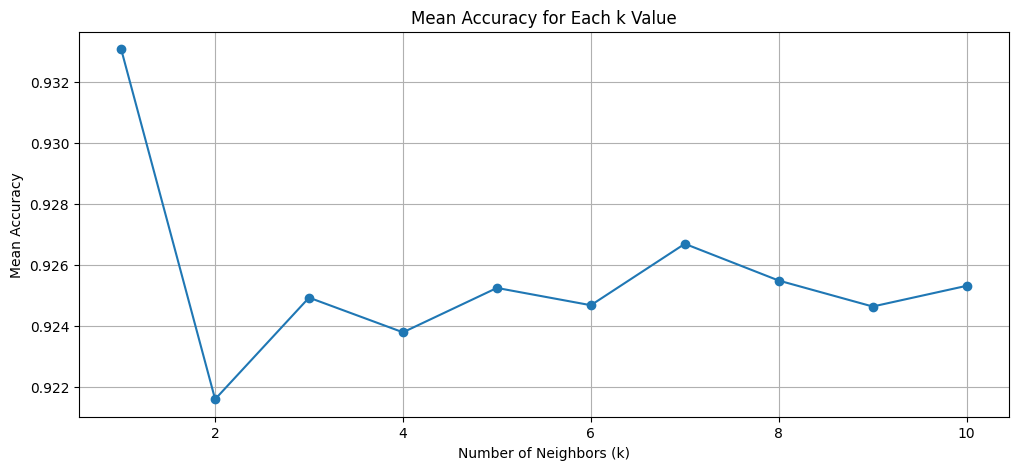

In [74]:
plt.figure(figsize=(12, 5))
plt.plot(list(mean_accuracies_k.keys()), list(mean_accuracies_k.values()), marker='o')
plt.title("Mean Accuracy for Each k Value")
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Mean Accuracy")
plt.grid(True)
plt.show()

Accuracy stabilization with increasing bootstrap iterations for the best k

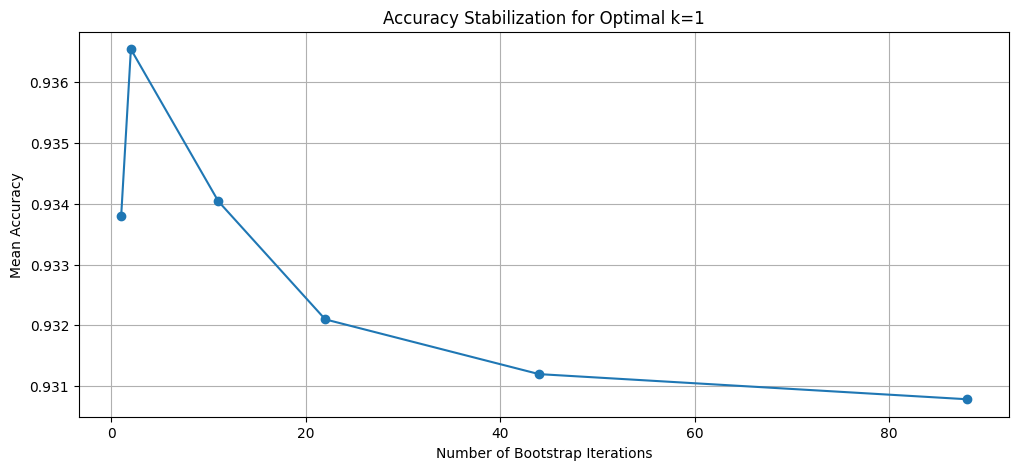

In [75]:
plt.figure(figsize=(12, 5))
plt.plot(bootstrap_iterations, stabilization_accuracies, marker='o')
plt.title(f"Accuracy Stabilization for Optimal k={optimal_k}")
plt.xlabel("Number of Bootstrap Iterations")
plt.ylabel("Mean Accuracy")
plt.grid(True)
plt.show()

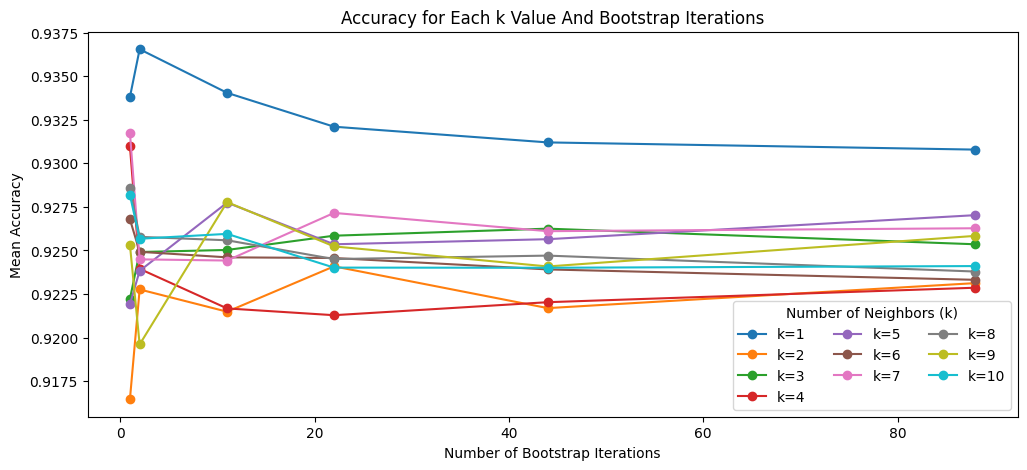

In [77]:
plt.figure(figsize=(12, 5))
for k in k_values:
    plt.plot(bootstrap_iterations, results[k], marker='o', label=f'k={k}')
plt.legend(loc='lower right', ncol=3, title='Number of Neighbors (k)')
plt.title('Accuracy for Each k Value And Bootstrap Iterations')
plt.xlabel("Number of Bootstrap Iterations")
plt.ylabel("Mean Accuracy")
plt.show()